<a href="https://colab.research.google.com/github/mateusz-kacpura/exercises-python/blob/main/RNN_i_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install keras

In [2]:
!wget https://www.gutenberg.org/cache/epub/1524/pg1524.txt

--2024-11-26 13:40:33--  https://www.gutenberg.org/cache/epub/1524/pg1524.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 207031 (202K) [text/plain]
Saving to: ‘pg1524.txt’

pg1524.txt          100%[===================>] 202.18K  --.-KB/s    in 0.08s   

2024-11-26 13:40:33 (2.54 MB/s) - ‘pg1524.txt’ saved [207031/207031]



In [3]:
import numpy as np
import nltk
nltk.download('stopwords')
from nltk import corpus
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, RNN, Input, Embedding, Layer
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras import activations
import tensorflow as tf

file_ = open('pg1524.txt').read()

# Funkcja `tokenize_text` przetwarza tekst wejściowy
# Argumenty:
#   input (str): Ciąg znaków, który ma zostać przetworzony.
# Działanie:
#   1. Zamiana wszystkich znaków w tekście na małe litery.
#   2. Tokenizacja tekstu przy użyciu wyrażenia regularnego, które
#      rozpoznaje ciągi alfanumeryczne (bez znaków interpunkcyjnych).
#   3. Filtrowanie tokenów, aby usunąć słowa znajdujące się
#      na liście angielskich "stop words" (czyli słów o niskiej wartości
#      informacyjnej, takich jak "and", "the", "is" itd.).
# Zwraca:
#   str: Ciąg znaków zawierający przetworzone tokeny oddzielone spacjami.

def tokenize_text(input):
    input = input.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(input)
    filtered = filter(lambda token: token not in stopwords.words('english'), tokens)
    return " ".join(filtered)

# Przetwarzanie wczytanego tekstu.
preprocesing_input = tokenize_text(file_)

# Generowanie słownika znaków i mapowanie każdego znaku na unikalny indeks.
chars = sorted(list(set(preprocesing_input)))
chars_to_num = dict((c, i) for i, c in enumerate(chars))

# Ustalanie długości danych wejściowych oraz słownika znaków.
input_len = len(preprocesing_input)
vocabulary_len = len(chars)

# Parametry generowania sekwencji.
seq_len = 100  # Długość sekwencji wejściowych.
x_data = []  # Lista przechowująca sekwencje wejściowe.
y_data = []  # Lista przechowująca przewidywane wartości wyjściowe.

# Generowanie danych sekwencyjnych dla modelu.
for i in range(0, input_len - seq_len, 1):
    input_seq = preprocesing_input[i:i + seq_len]  # Fragment tekstu wejściowego o ustalonej długości.
    output_seq = preprocesing_input[i + seq_len]  # Następny znak po sekwencji wejściowej.
    x_data.append([chars_to_num[char] for char in input_seq])  # Kodowanie sekwencji wejściowej na indeksy.
    y_data.append(chars_to_num[output_seq])  # Kodowanie znaku wyjściowego na indeks.

# Liczba wygenerowanych sekwencji.
n_patterns = len(x_data)

# Przekształcanie danych wejściowych do odpowiedniego formatu dla modelu.
x = np.reshape(x_data, (n_patterns, seq_len))  # Reshape danych wejściowych do postaci [próbki, sekwencja].
x = x / float(vocabulary_len)  # Normalizacja wartości do zakresu [0, 1].
y = to_categorical(y_data, num_classes=vocabulary_len)  # One-hot encoding danych wyjściowych.

# Tworzenie zbioru danych w postaci `tf.data.Dataset` z szuflowaniem i batchowaniem.
batch_size = 64  # Rozmiar batcha.
dataset = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(10000).batch(batch_size, drop_remainder=True)

# Klasa SimpleRNN implementuje niestandardową warstwę RNN.
# Argumenty:
#   units (int): Liczba jednostek w warstwie RNN.
#   activation (str): Funkcja aktywacji stosowana w warstwie.
class SimpleRNN(Layer):
    def __init__(self, units, activation='tanh', **kwargs):
        super(SimpleRNN, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)

    @property
    def state_size(self):
        return self.units

    @property
    def output_size(self):
        return self.units

    def build(self, input_shape):
        self.input_dim = input_shape[-1]  # Rozmiar wektora wejściowego.
        self.W_h = self.add_weight(shape=(self.units, self.units), initializer='glorot_uniform', name='W_h')  # Wagi dla poprzedniego stanu ukrytego.
        self.W_x = self.add_weight(shape=(self.input_dim, self.units), initializer='glorot_uniform', name='W_x')  # Wagi dla wejścia.
        self.b_h = self.add_weight(shape=(self.units,), initializer='zeros', name='b')  # Biasy.
        super(SimpleRNN, self).build(input_shape)

    def call(self, inputs, states):
        prev_output = states[0]  # Poprzedni stan ukryty.
        h = self.activation(tf.matmul(inputs, self.W_x) + tf.matmul(prev_output, self.W_h) + self.b_h)  # Obliczenie nowego stanu ukrytego.
        return h, [h]

# Definiowanie architektury modelu.
inputs = Input(shape=(seq_len,))  # Warstwa wejściowa o kształcie odpowiadającym długości sekwencji.
embedding_dim = 256  # Wymiar embeddingu.
x = Embedding(vocabulary_len, embedding_dim)(inputs)  # Warstwa embeddingu przekształcająca indeksy znaków na wektory ciągłe.
rnn_cell = SimpleRNN(1024)  # Warstwa RNN z 1024 jednostkami.
x = RNN(rnn_cell, return_sequences=False)(x)  # Przepływ danych przez warstwę RNN.
output = Dense(vocabulary_len, activation='softmax')(x)  # Warstwa wyjściowa z funkcją softmax do przewidywania następnego znaku.

# Kompilacja modelu.
model = Model(inputs, output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Trenowanie modelu na przygotowanym zbiorze danych.
history = model.fit(dataset, epochs=10)  # Trenowanie przez 10 epok.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 88s 45ms/step - accuracy: 0.1273 - loss: 3.0647
Epoch 2/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 148s 50ms/step - accuracy: 0.1306 - loss: 3.0304
Epoch 3/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 87s 46ms/step - accuracy: 0.1323 - loss: 3.0326
Epoch 4/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 86s 46ms/step - accuracy: 0.1330 - loss: 3.0260
Epoch 5/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 143s 46ms/step - accuracy: 0.1352 - loss: 3.0253
Epoch 6/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 90s 48ms/step - accuracy: 0.1327 - loss: 3.0279
Epoch 7/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 143s 48ms/step - accuracy: 0.1335 - loss: 3.0229
Epoch 8/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 86s 46ms/step - accuracy: 0.1313 - loss: 3.0278
Epoch 9/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 86s 46ms/step - accuracy: 0.1317 - loss: 3.0318
Epoch 10/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 142s 46ms/step - accuracy: 0.1316 - loss: 3.0300


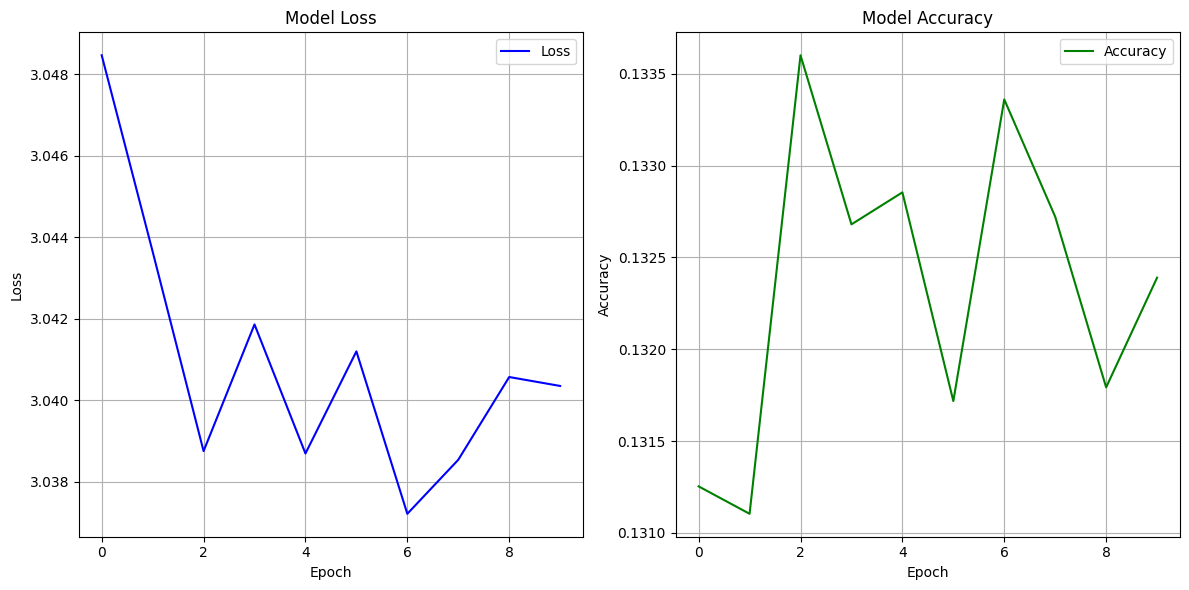

In [4]:
import matplotlib.pyplot as plt
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Wykres strat
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss', color='blue')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Wykres dokładności
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Accuracy', color='green')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [5]:
class CustomLSTMCell(Layer):
    def __init__(self, units, activation='tanh', recurrent_activation='sigmoid', **kwargs):
        super(CustomLSTMCell, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.recurrent_activation = activations.get(recurrent_activation)

    @property
    def state_size(self):
        return [self.units, self.units]  # [hidden_state, cell_state]

    @property
    def output_size(self):
        return self.units

    def build(self, input_shape):
        self.input_dim = input_shape[-1]
        # Weights for input gate
        self.W_xi = self.add_weight(shape=(self.input_dim, self.units), initializer='glorot_uniform', name='W_xi')
        self.W_hi = self.add_weight(shape=(self.units, self.units), initializer='glorot_uniform', name='W_hi')
        self.b_i = self.add_weight(shape=(self.units,), initializer='zeros', name='b_i')

        # Weights for forget gate
        self.W_xf = self.add_weight(shape=(self.input_dim, self.units), initializer='glorot_uniform', name='W_xf')
        self.W_hf = self.add_weight(shape=(self.units, self.units), initializer='glorot_uniform', name='W_hf')
        self.b_f = self.add_weight(shape=(self.units,), initializer='zeros', name='b_f')

        # Weights for cell state
        self.W_xc = self.add_weight(shape=(self.input_dim, self.units), initializer='glorot_uniform', name='W_xc')
        self.W_hc = self.add_weight(shape=(self.units, self.units), initializer='glorot_uniform', name='W_hc')
        self.b_c = self.add_weight(shape=(self.units,), initializer='zeros', name='b_c')

        # Weights for output gate
        self.W_xo = self.add_weight(shape=(self.input_dim, self.units), initializer='glorot_uniform', name='W_xo')
        self.W_ho = self.add_weight(shape=(self.units, self.units), initializer='glorot_uniform', name='W_ho')
        self.b_o = self.add_weight(shape=(self.units,), initializer='zeros', name='b_o')

        super(CustomLSTMCell, self).build(input_shape)

    def call(self, inputs, states):
        h_tm1 = states[0]  # poprzedni stan ukryty
        c_tm1 = states[1]  # poprzedni stan komórki

        # Bramka wejścia
        i = self.recurrent_activation(tf.matmul(inputs, self.W_xi) + tf.matmul(h_tm1, self.W_hi) + self.b_i)
        # Bramka zapominania
        f = self.recurrent_activation(tf.matmul(inputs, self.W_xf) + tf.matmul(h_tm1, self.W_hf) + self.b_f)
        # Kandydat na stan komórki
        c_hat = self.activation(tf.matmul(inputs, self.W_xc) + tf.matmul(h_tm1, self.W_hc) + self.b_c)
        # Aktualizacja stanu komórki
        c_t = f * c_tm1 + i * c_hat
        # Bramka wyjścia
        o = self.recurrent_activation(tf.matmul(inputs, self.W_xo) + tf.matmul(h_tm1, self.W_ho) + self.b_o)
        # Aktualizacja stanu ukrytego
        h_t = o * self.activation(c_t)

        return h_t, [h_t, c_t]

# Definiujemy model z użyciem CustomLSTMCell
inputs = Input(shape=(seq_len,))
embedding_dim = 256
x = Embedding(vocabulary_len, embedding_dim)(inputs)
lstm_cell = CustomLSTMCell(1024)
x = RNN(lstm_cell, return_sequences=False)(x)
output = Dense(vocabulary_len, activation='softmax')(x)
model = Model(inputs, output)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(dataset, epochs=10)


Epoch 1/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 325s 171ms/step - accuracy: 0.1515 - loss: 2.9364
Epoch 2/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 322s 171ms/step - accuracy: 0.1555 - loss: 2.9131
Epoch 3/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 329s 175ms/step - accuracy: 0.1550 - loss: 2.9108
Epoch 4/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 321s 171ms/step - accuracy: 0.1549 - loss: 2.9100
Epoch 5/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 322s 171ms/step - accuracy: 0.1538 - loss: 2.9122
Epoch 6/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 321s 171ms/step - accuracy: 0.1544 - loss: 2.9113
Epoch 7/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 322s 171ms/step - accuracy: 0.1539 - loss: 2.9113
Epoch 8/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 321s 170ms/step - accuracy: 0.1537 - loss: 2.9110
Epoch 9/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 321s 171ms/step - accuracy: 0.1551 - loss: 2.9083
Epoch 10/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 323s 171ms/step - accuracy: 0.1544 - loss: 2.9079


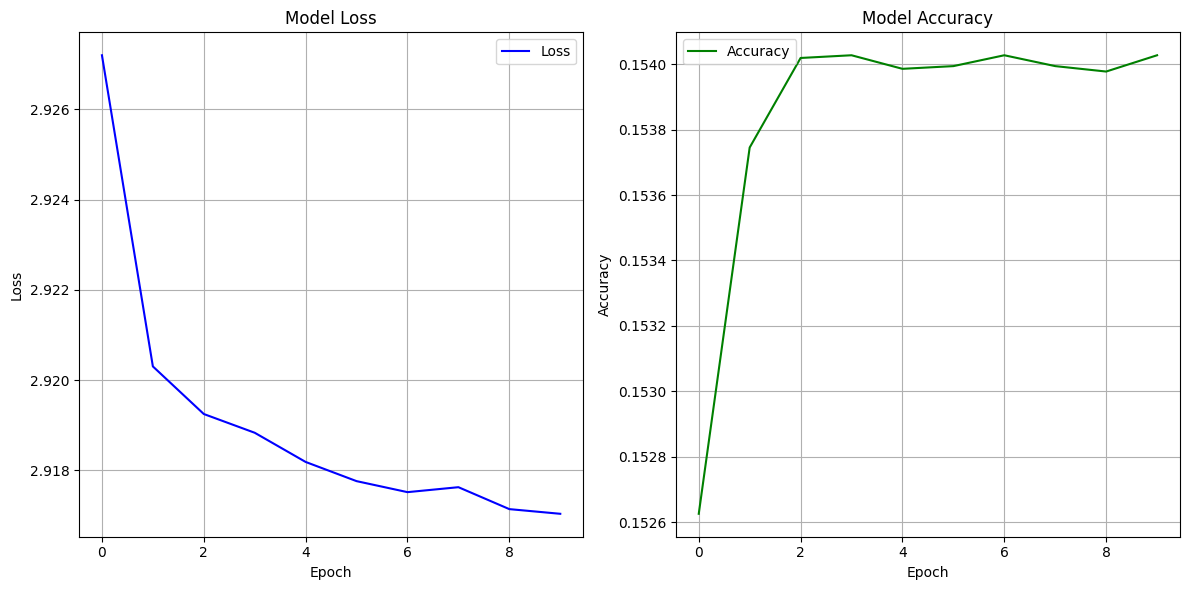

In [6]:
plot_training_history(history)